# Double Descent
Figures for the blog post [Double descent in human learning](https://chris-said.io/2023/04/21/double-descent-in-human-learning/)

Figures are adapted from this [blog post](https://windowsontheory.org/2019/12/05/deep-double-descent/) and [notebook](https://colab.research.google.com/drive/1oMuUz3_BOENSoaOVOymLoB2mHeYBex8S) by Preetum Nakkiran


In [ ]:
import numpy as np
import numpy.random as rand
import numpy.linalg as la
import pylab as plt
import pandas as pd
from numpy.polynomial.legendre import legvander
from typing import Callable

In [ ]:
blue='#3ac3f2'
pink='#ed2685'
gray='#aaaaaa'

In [ ]:
class LegendrePolynomialRegression:
    def __init__(self, deg: int, lamb: float=0):
        self.deg = deg
        self.lamb = lamb

    def fit(self, x: np.array, y: np.array):
        A = legvander(x, self.deg)
        if self.lamb == 0:
            self.beta = la.pinv(A).dot(y) # unregularized, but still using minimum norm as a tiebreaker (just as gradient descent does)
        else:
            self.beta = la.solve(A.T.dot(A) + self.lamb * np.identity(A.shape[1]), A.T.dot(y)) # regularized

    def predict(self, x: np.array):
        return legvander(x, self.deg).dot(self.beta)

In [ ]:
def cubic_gt(x: np.array):
    b = np.array([0, -1, 0, 1])
    return np.polynomial.legendre.legvander(x, 3).dot(b)

def get_mse(y: np.array, preds: np.array):
    return np.mean((preds-y)**2)

def generate_data(x: np.array, true_func: Callable, sigma: float):
    return true_func(x) + sigma*rand.normal(size=len(x))

def plot_fit(xdense: np.array,
             ygt: np.array,
             xtrain: np.array,
             ytrain: np.array,
             yfit: np.array,
             xtest: np.array=None,
             ytest: np.array=None,
            ):
    plt.plot(xdense, ygt, label='True function', color=gray)
    plt.plot(xdense, yfit, label='Model fit', color=pink)
    plt.scatter(xtrain, ytrain, label='Train samples', color=blue, zorder=100)
    if xtest and ytest:
        plt.scatter(xtest, ytest, label='Test samples', color=green, zorder=100)
    plt.ylim(-2, 2)
    plt.axis('off')
    plt.legend()

In [ ]:
def run_2d(true_func: Callable=cubic_gt, sigma=0.3, lamb=0, max_deg=100, max_ntrain=100, ntest=100):
    ntrains = range(1, max_ntrain)
    degs = range(1, max_deg)
    mses_2d = np.empty([len(ntrains), len(degs)])
    for i, ntrain in enumerate(ntrains):
        xtrain = np.linspace(-1, 1, ntrain)
        xtest = np.linspace(-1, 1, ntest)
        ytrain = generate_data(xtrain, true_func, sigma)
        ytest = generate_data(xtest, true_func, sigma)

        for j, deg in enumerate(degs):
            mod = LegendrePolynomialRegression(deg=deg, lamb=lamb)
            mod.fit(xtrain, ytrain)
            preds = mod.predict(xtest)
            mse = get_mse(ytest, preds)
            mses_2d[i,j] = mse
    return mses_2d


## Test error as a function of num parameters and num training samples
I used this plot to identify good values to show for the parameter double descent and the data double descent examples below.


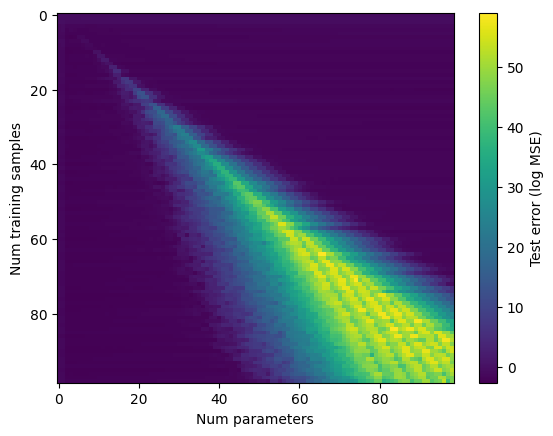

In [ ]:
mses_2d = run_2d()
plt.imshow(np.log(mses_2d), aspect='auto')
plt.xlabel('Num parameters')
plt.ylabel('Num training samples')
plt.colorbar(label='Test error (log MSE)')

## Example fits

In [ ]:
def sample_fit_plot(training_df: pd.DataFrame, xdense: np.array, ygt: np.array, ntrain: int, deg: int):
    sampled_training_df = training_df.sample(ntrain)
    mod = LegendrePolynomialRegression(deg=deg)
    mod.fit(sampled_training_df['x'], sampled_training_df['y'])
    preds = mod.predict(xdense)
    plot_fit(xdense, ygt, sampled_training_df['x'], sampled_training_df['y'], preds)

In [ ]:
max_ntrain = 200
sigma = 0.3
xdense = np.linspace(-1, 1, 100)
true_func = cubic_gt
ygt = true_func(xdense)
xtrain = np.linspace(-1, 1, max_ntrain)
training_df = pd.DataFrame({
    'x': xtrain,
    'y': generate_data(xtrain, true_func, sigma)
})


#### As a function of num parameters

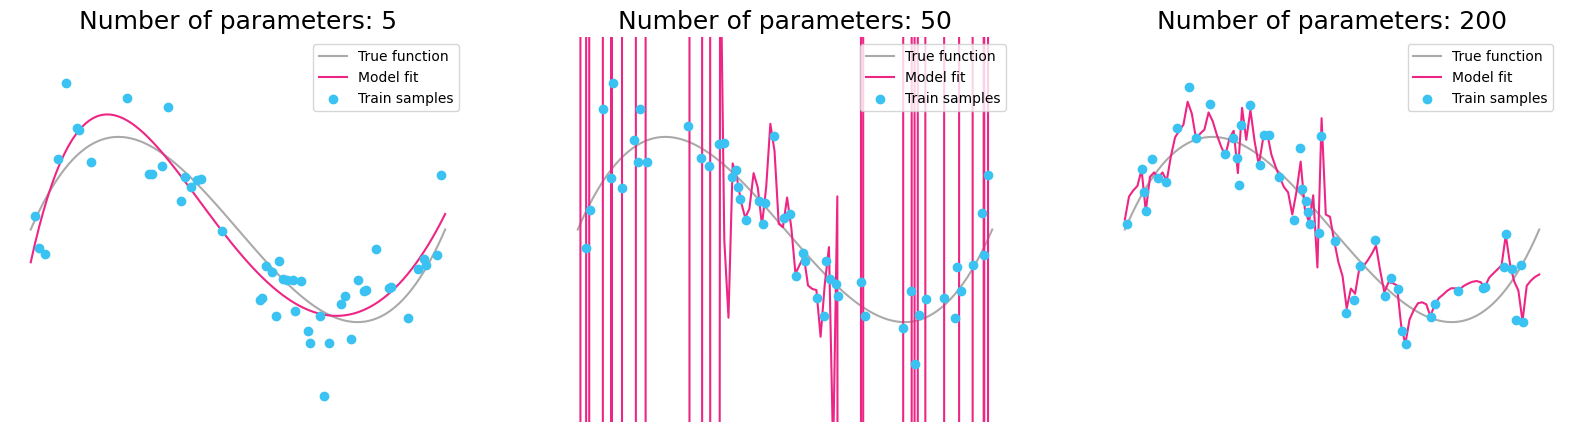

In [ ]:
ntrain = 50
fig, axes = plt.subplots(1, 3, figsize=[20, 5])
for i, deg in enumerate([5, 50, 200]):
    plt.sca(axes[i])
    sample_fit_plot(training_df, xdense, ygt, ntrain, deg)
    plt.title(f"Number of parameters: {deg}", fontsize=18)

#### As a function of training sample size

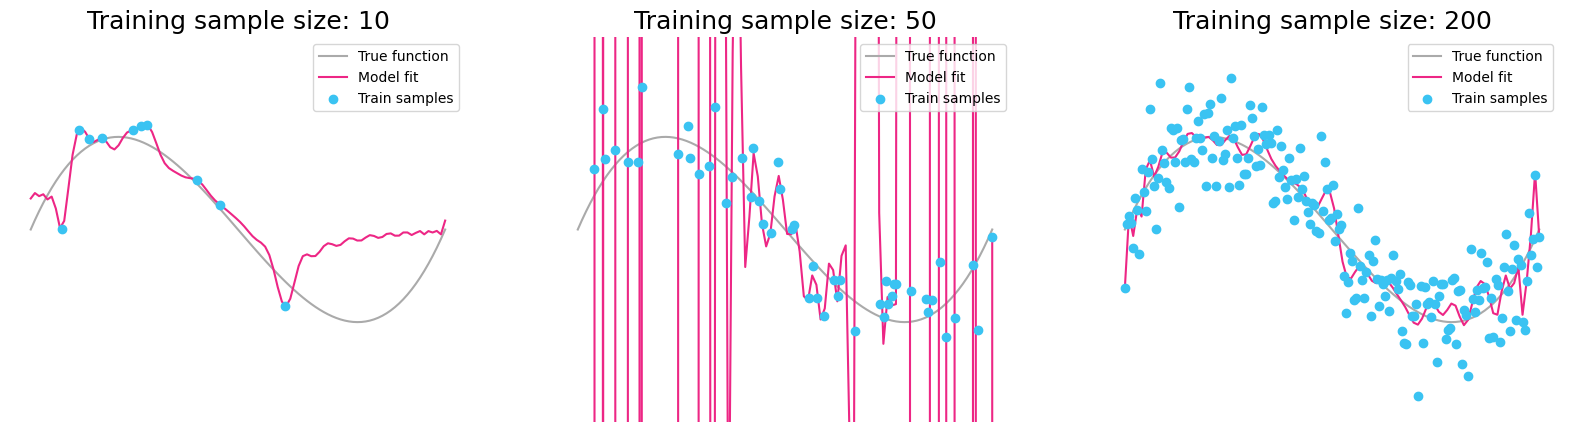

In [ ]:
deg = 50
fig, axes = plt.subplots(1, 3, figsize=[20, 5])
for i, ntrain in enumerate([10, 50, 200]):
    plt.sca(axes[i])
    sample_fit_plot(training_df, xdense, ygt, ntrain, deg)
    plt.title(f"Training sample size: {ntrain}", fontsize=18)